<a href="https://colab.research.google.com/github/ishikabhosale/Hurricane_classification/blob/main/Hurricane_classification_SOTA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying buildings Post Hurricane using Satellite Imagery



## Problem Statement

The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, we classify buildings between damaged and not damaged buildings using the satellite imagery data provided. 

## Approach to Solve the Problem 

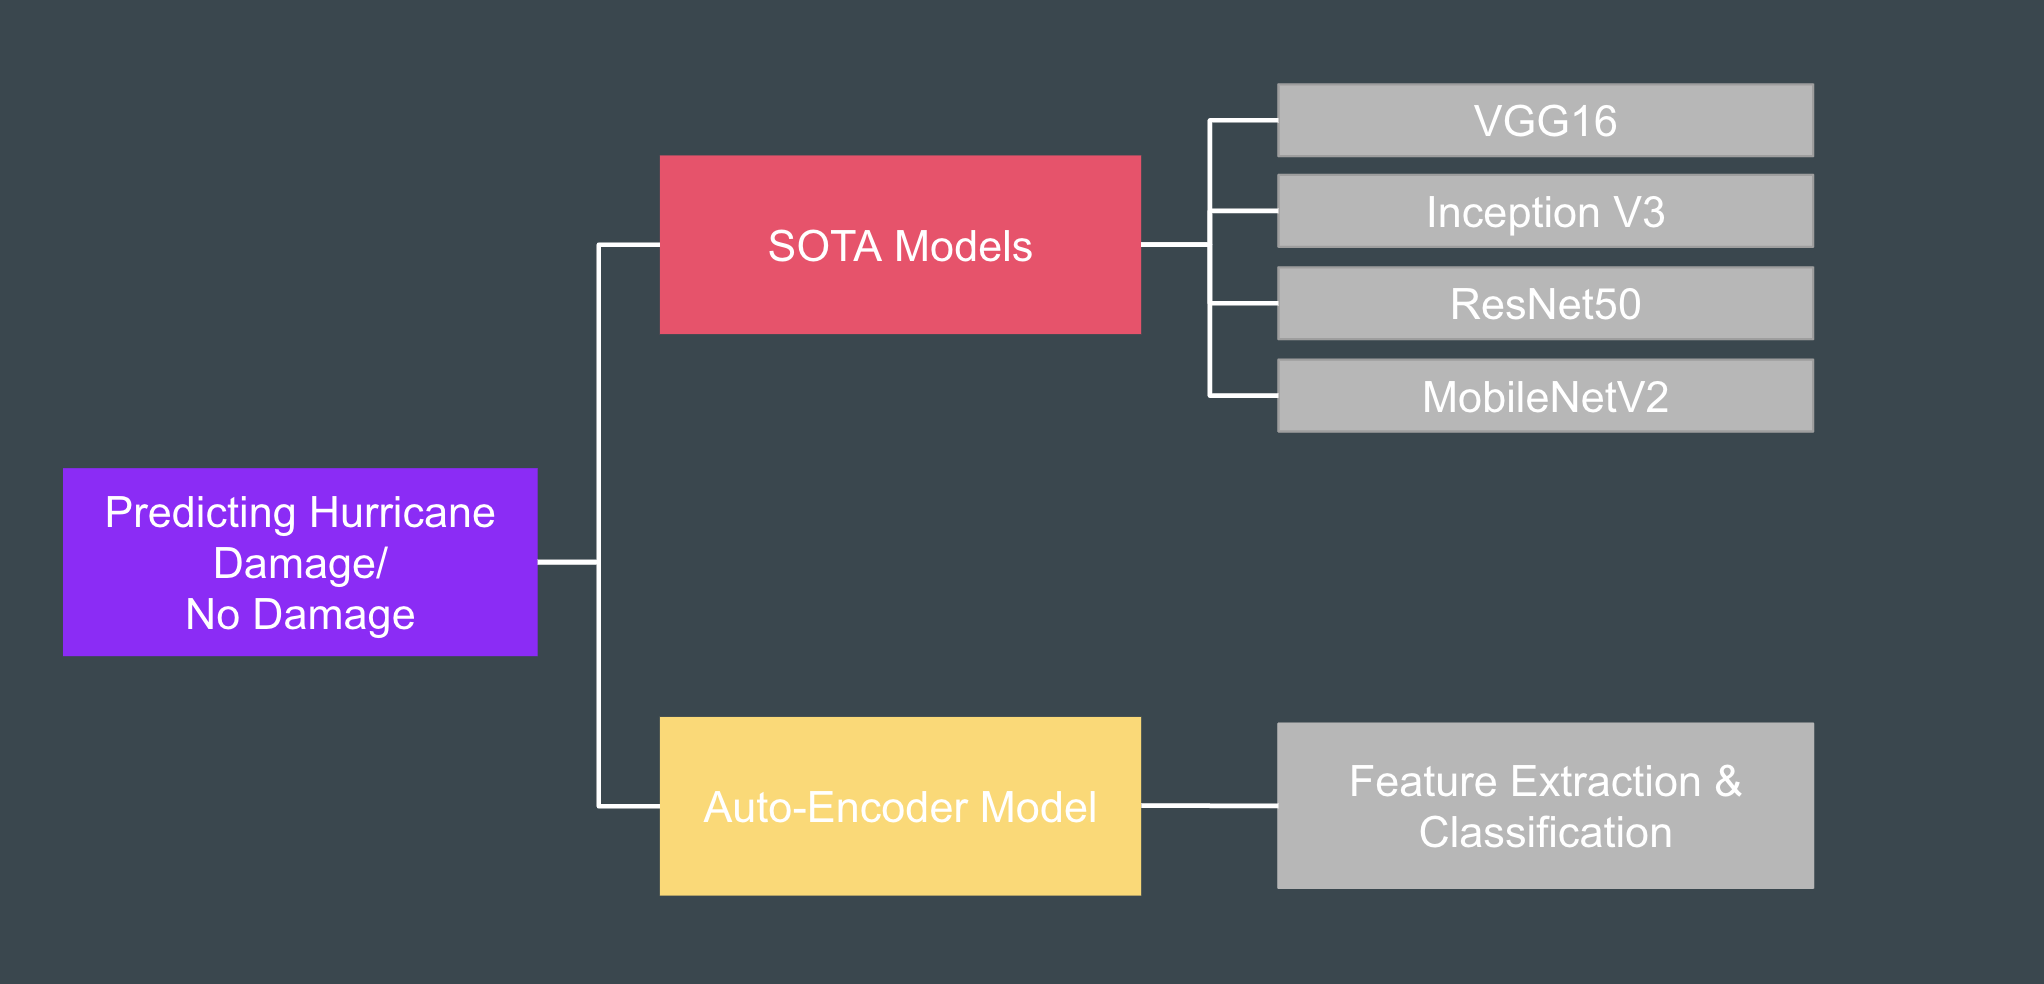

## Modelling - SOTA models


**VGG16:** 16 layer model that stacks convolutions and finishes with a dense layer. 

**Inception V3:** Uses multiple kernel sizes on the same layer making the architecture wider, then deeper. 

**ResNet50:** Used to build deeper models using skip connections to simultaneously find a optimised number of layers to negate the vanishing gradient problem.

**MobileNetV2:** Uses depth wise separable convolutions which significantly reduces the number of parameters. 

The test_another dataset has an 8:1 class imbalance in favour of damaged buildings. This can result in a bias in classification towards the majority class. 


## Modelling - Auto Encoders

We used an autoencoder model to encode and decode the image to produce the code of the image. The idea is to see if the code of the image is able to capture key difference in the two classes. This code is then fed to a FNN as features to learn from to classify

## Methodology

Dataset - A collection of satellite images consisting of both damaged and non-damaged buildings post-hurricane served as the dataset. It was divided into four sub-folders for training, validation and, testing. Testing will be done on two datasets - one with balanced classes and the other with imbalanced classes

train_another: the training data; 5000 images of each class(damage/no damage)

validation_another: the validation data; 1000 images of each class(damage/no damage)

test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes

test: the balanced test data; 1000 images of each class(damage/no damage)

## Libraries Used 


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm

import seaborn as sns

import os
import json
from tqdm import tqdm

import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import UpSampling2D, LeakyReLU, Lambda


In [ ]:
# importing the required libraries
!pip -qq install tf_keras_vis 
%matplotlib inline
plt.style.use('ggplot')

import warnings
import glob
import pickle
import zipfile
import tensorflow as tf
from tensorflow.keras import layers
from __future__ import print_function
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from PIL import Image
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from tensorflow.keras import optimizers
from sklearn import metrics



from scipy.signal import convolve2d
%matplotlib inline
from tensorflow.keras.utils import to_categorical
import certifi
import urllib3  
import scipy.ndimage as ndimage
import tensorflow_datasets as tfds


     |████████████████████████████████| 53 kB 1.4 MB/s 


In [ ]:
!pip install google.colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading Datasets

In [ ]:
!unzip "/content/gdrive/MyDrive/Post-hurricane.zip" -d "/content/Post-hurricane-CV"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.627563_29.8628.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.627579_29.864051.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/no_damage/-95.627595_29.776602.jpeg  
  inflating: /content/Post-hurricane-CV/train_another/

In [ ]:
train_another = '/content/Post-hurricane-CV/train_another'
validation_another = '/content/Post-hurricane-CV/validation_another'
test = '/content/Post-hurricane-CV/test'
test_another = '/content/Post-hurricane-CV/test_another'

In [ ]:
#Converting Datasets to Generators. Keras Image Generator enables us to augment data in real time while the model is still training.

In [ ]:
# We choose mobile preprocess_input be we can apply custom augmentations too
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Takes the path to a directory & generates batches of augmented data.
train_generator = datagen.flow_from_directory(train_another, batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 10000 images belonging to 2 classes.


In [ ]:
validation_generator = datagen.flow_from_directory(validation_another,  batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 2000 images belonging to 2 classes.


In [ ]:
test_generator1 = datagen.flow_from_directory(test,batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 2000 images belonging to 2 classes.


In [ ]:
test_generator2 = datagen.flow_from_directory(test_another, batch_size = 64, class_mode = 'binary', classes= ['no_damage', 'damage'])

Found 9000 images belonging to 2 classes.


### Printing Sample Image 

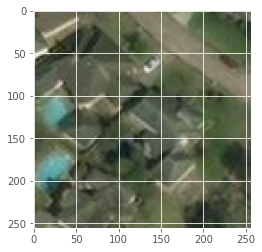

In [ ]:
plt.imshow(train_generator_en.next()[0][6])

## SOTA Models


### VGG 16 Model


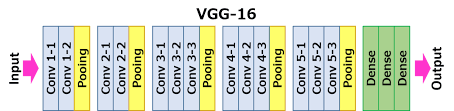

In [ ]:
vgg = VGG16(include_top= True, weights=None, classes=1, classifier_activation='sigmoid',   input_shape=(256, 256, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
# vgg.load_weights('/content/gdrive/MyDrive/vgg_weights_p2.h5') #loading the weights

In [ ]:
vgg.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
history = vgg.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=5,verbose=1)

Epoch 1/5
157/157 [==============================] - 375s 2s/step - loss: 0.7479 - accuracy: 0.5012 - val_loss: 0.6932 - val_accuracy: 0.4969
Epoch 2/5
157/157 [==============================] - 323s 2s/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 3/5
157/157 [==============================] - 323s 2s/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4984
Epoch 4/5
157/157 [==============================] - 323s 2s/step - loss: 0.6932 - accuracy: 0.4950 - val_loss: 0.6932 - val_accuracy: 0.4719
Epoch 5/5
157/157 [==============================] - 323s 2s/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.4828


In [ ]:
with open('/content/gdrive/MyDrive/vgg_orientation.json', 'w') as file:
  json.dump(history.history, file)

In [ ]:
vgg.save_weights('/content/gdrive/MyDrive/vgg_weights_p2.h5')

#### Evaluating VGG Model

In [ ]:
with open('/content/gdrive/MyDrive/vgg_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'VGG Model accuracy and loss')

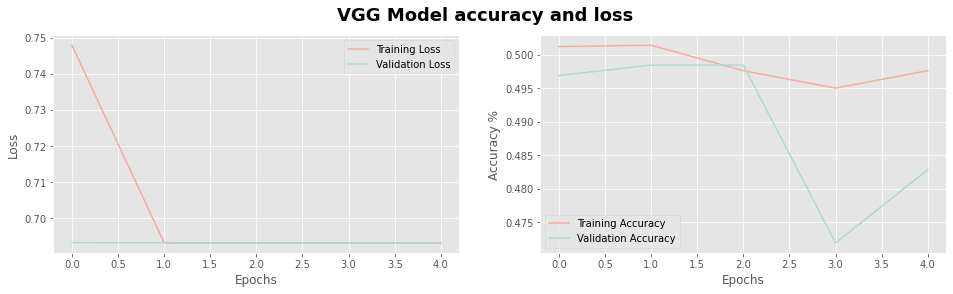

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('VGG Model accuracy and loss', fontsize = 18, fontweight= 'bold')

**Inference:** The model does not seem to have captured the features of damaged and no damaged class and the accuracy is no better than a random guess

In [ ]:
vgg_eval_train = vgg.evaluate(train_generator)
vgg_eval_train

157/157 [==============================] - 90s 571ms/step - loss: 0.6931 - accuracy: 0.5000


[0.693148136138916, 0.5]

In [ ]:
vgg_eval_val = vgg.evaluate(validation_generator)
vgg_eval_val

32/32 [==============================] - 18s 563ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931477189064026, 0.5]

In [ ]:
vgg_eval_test1 = vgg.evaluate(test_generator1)
vgg_eval_test1

32/32 [==============================] - 18s 562ms/step - loss: 0.6931 - accuracy: 0.5000


[0.6931477189064026, 0.5]

In [ ]:
vgg_eval_test2 = vgg.evaluate(test_generator2)
vgg_eval_test2

141/141 [==============================] - 97s 688ms/step - loss: 0.6923 - accuracy: 0.8889


[0.692293107509613, 0.8888888955116272]

**Inference**: Three datasets the model have accuracy at 50%, which is no better than a random gues s. A higher accuracy for the unbalanced dataset (test another) can be explained due to class imbalance 

#### Saliency Maps for VGG Model

In [ ]:
# The `output` variable refer to the output of the model,
def loss(output):
    return (output[0][0])

In [ ]:
def model_modifier(m): #Change last activation layer to linear
    m.layers[-1].activation = tf.keras.activations.linear
    return m

In [ ]:
#Saliency Map
saliency_vgg = Saliency(vgg,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_vgg = Gradcam(vgg,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
vgg_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_vgg_test1 = saliency_vgg(loss,
                        np.float32(vgg_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_vgg_test1 = normalize(saliency_vgg_test1)

In [ ]:
#GradCam
gradcam_vgg_test1 = gradcam_vgg(loss, 
              np.float32(vgg_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_vgg_test1 = normalize(gradcam_vgg_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


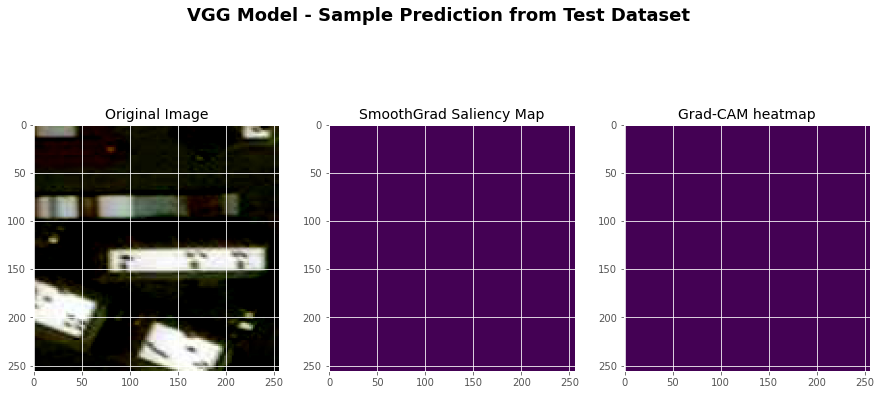

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("VGG Model - Sample Prediction from Test Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_vgg_test1[0], gradcam_vgg_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
vgg_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_vgg_test2 = saliency_vgg(loss,
                        np.float32(vgg_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_vgg_test2 = normalize(saliency_vgg_test2)

In [ ]:
#GradCam
gradcam_vgg_test2 = gradcam_vgg(loss, 
              np.float32(vgg_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_vgg_test2 = normalize(gradcam_vgg_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


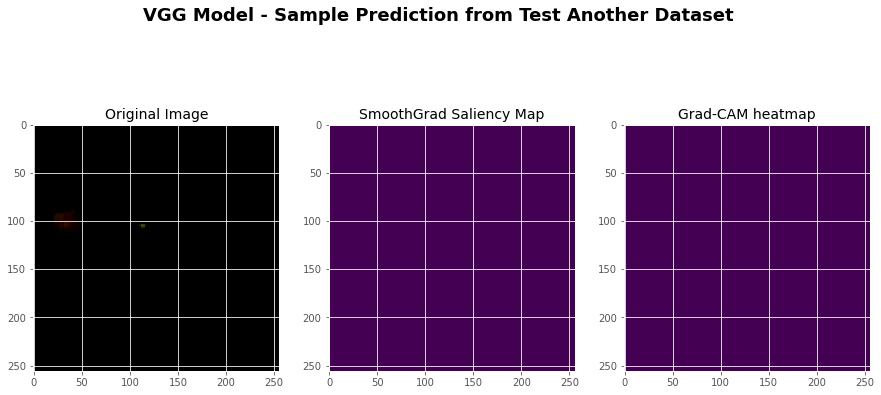

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("VGG Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator2.next()[0][6], saliency_vgg_test2[0], gradcam_vgg_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

**Inference**:  Looking at the saliency of the observation, it is clear that the model has failed to capture essential details of the image that is essential for classification and is hence performing poorly.

### Inception V3 Model

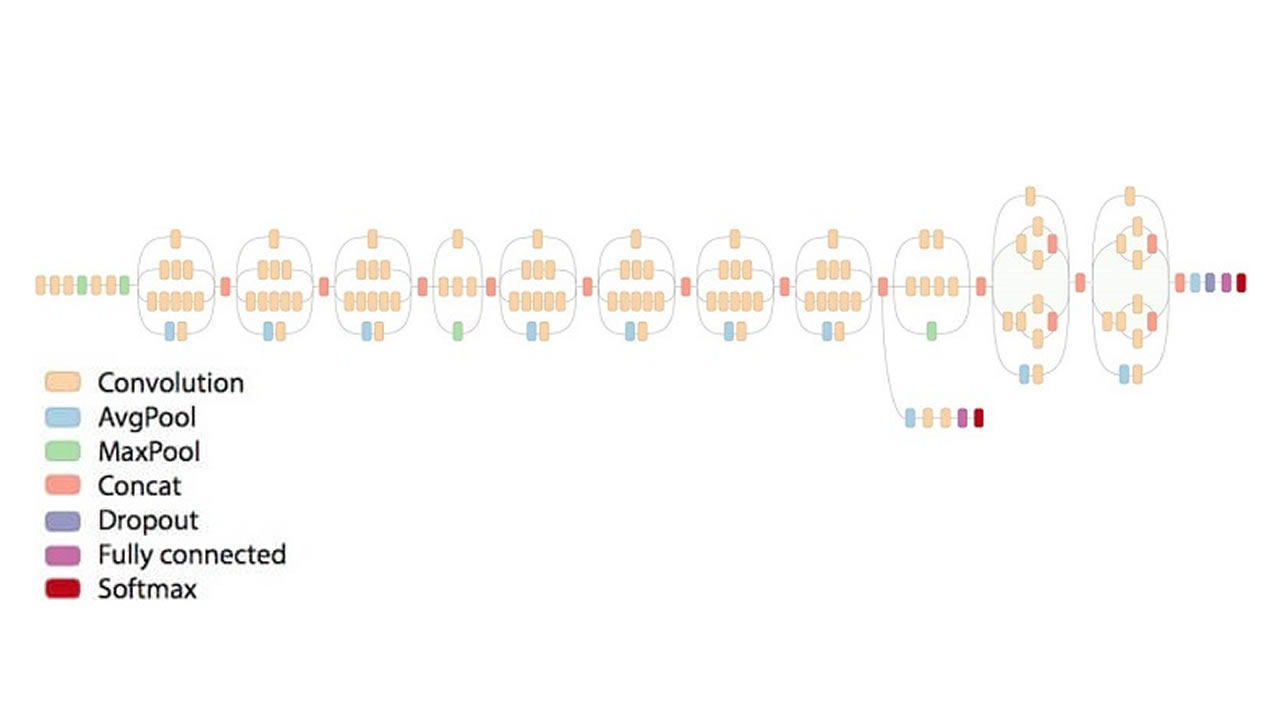

In [ ]:
inception_model = InceptionV3(include_top= True, weights=None, classes=1, classifier_activation='sigmoid',  input_shape=(256, 256, 3))

inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# inception_model.load_weights('/content/gdrive/MyDrive/inception_model_weights_p2.h5') #loading the weights

In [ ]:
inception_model.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
history = inception_model.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=5, verbose=1)

Epoch 1/5
157/157 [==============================] - 243s 1s/step - loss: 0.2357 - accuracy: 0.9144 - val_loss: 2.9912 - val_accuracy: 0.4844
Epoch 2/5
157/157 [==============================] - 223s 1s/step - loss: 0.1477 - accuracy: 0.9414 - val_loss: 2.3948 - val_accuracy: 0.5703
Epoch 3/5
157/157 [==============================] - 223s 1s/step - loss: 0.1072 - accuracy: 0.9636 - val_loss: 0.4493 - val_accuracy: 0.8016
Epoch 4/5
157/157 [==============================] - 223s 1s/step - loss: 0.0843 - accuracy: 0.9673 - val_loss: 1.5676 - val_accuracy: 0.7812
Epoch 5/5
157/157 [==============================] - 223s 1s/step - loss: 0.0733 - accuracy: 0.9746 - val_loss: 0.4579 - val_accuracy: 0.7750


In [ ]:
import json
with open('/content/gdrive/MyDrive/inception_orientation.json', 'w') as file:
  json.dump(history.history, file)

In [ ]:
inception_model.save_weights('/content/gdrive/MyDrive/inception_model_weights_p2.h5')

#### Evaluating Inception Model

In [ ]:
with open('/content/gdrive/MyDrive/inception_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'Inception V3 Model accuracy and loss')

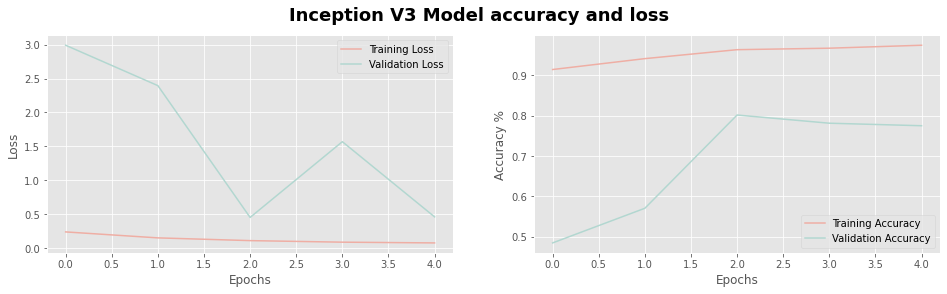

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Inception V3 Model accuracy and loss', fontsize = 18, fontweight= 'bold')

**Inference**: In just 2 epochs, the loss is very close to zero and the accuracy on the validation reaches a good 96%. Let's look at the model's performance on test and test another datasets


In [ ]:
inception_eval_train = inception_model.evaluate(train_generator)
inception_eval_train

157/157 [==============================] - 62s 392ms/step - loss: 0.5156 - accuracy: 0.7679


[0.515580952167511, 0.7678999900817871]

In [ ]:
inception_eval_val = inception_model.evaluate(validation_generator)
inception_eval_val

32/32 [==============================] - 12s 385ms/step - loss: 0.5008 - accuracy: 0.7850


[0.5007765889167786, 0.7850000262260437]

In [ ]:
inception_eval_test1= inception_model.evaluate(test_generator1)
inception_eval_test1

32/32 [==============================] - 13s 385ms/step - loss: 0.5406 - accuracy: 0.7655


[0.5405915379524231, 0.765500009059906]

In [ ]:
inception_eval_test2 = inception_model.evaluate(test_generator2)
inception_eval_test2

141/141 [==============================] - 58s 407ms/step - loss: 0.4602 - accuracy: 0.8172


[0.46016010642051697, 0.8172222375869751]

**Inference**: The model generalises well on both the test datasets. Test dataset has an accuracy of 0.76 and the test_another dataset has an accuracy of 0.81

#### Saliency Maps for Inception Model

In [ ]:
#Saliency Map
saliency_inception = Saliency(inception_model,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_inception = Gradcam(inception_model,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
inception_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_inception_test1 = saliency_inception(loss,
                        np.float32(inception_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_inception_test1 = normalize(saliency_inception_test1)

In [ ]:
#GradCam
gradcam_inception_test1 = gradcam_inception(loss, 
              np.float32(inception_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_inception_test1 = normalize(gradcam_inception_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


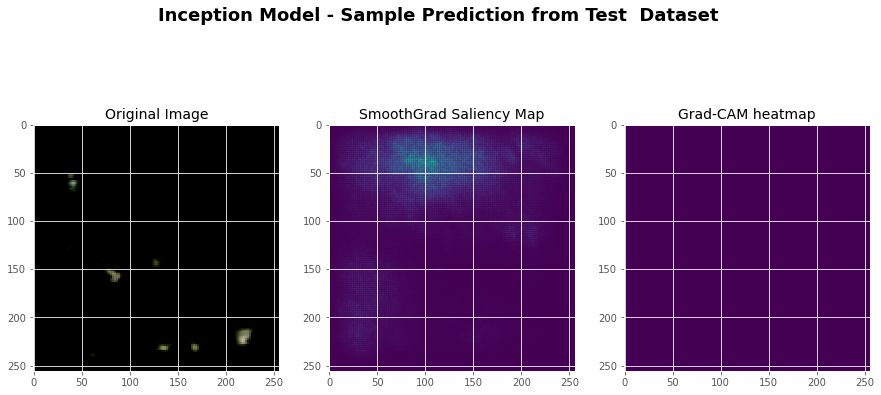

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Inception Model - Sample Prediction from Test  Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_inception_test1[0], gradcam_inception_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
inception_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_inception_test2 = saliency_inception(loss,
                        np.float32(inception_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_inception_test2 = normalize(saliency_inception_test2)

In [ ]:
#GradCam
gradcam_inception_test2 = gradcam_inception(loss, 
              np.float32(inception_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_inception_test2 = normalize(gradcam_inception_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


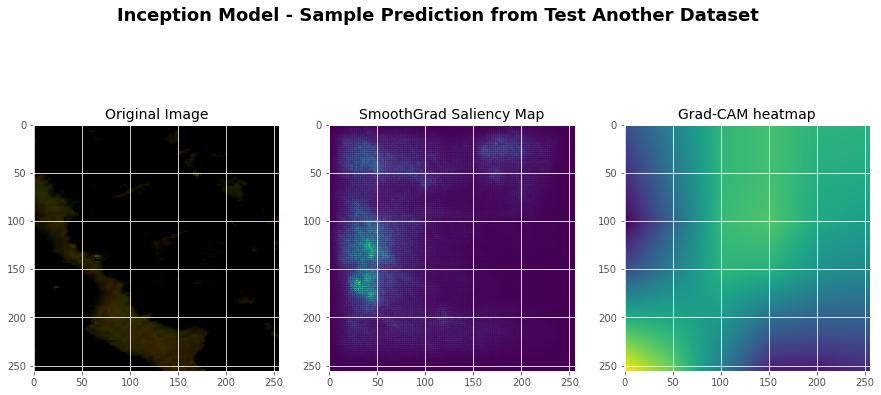

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Inception Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_inception_test2[0], gradcam_inception_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

**Inference**: Looking at the saliency it is clear that the inception model is picking up on crucial details and it seems like the model is paying attention to the buildings. 

### ResNet50 Model


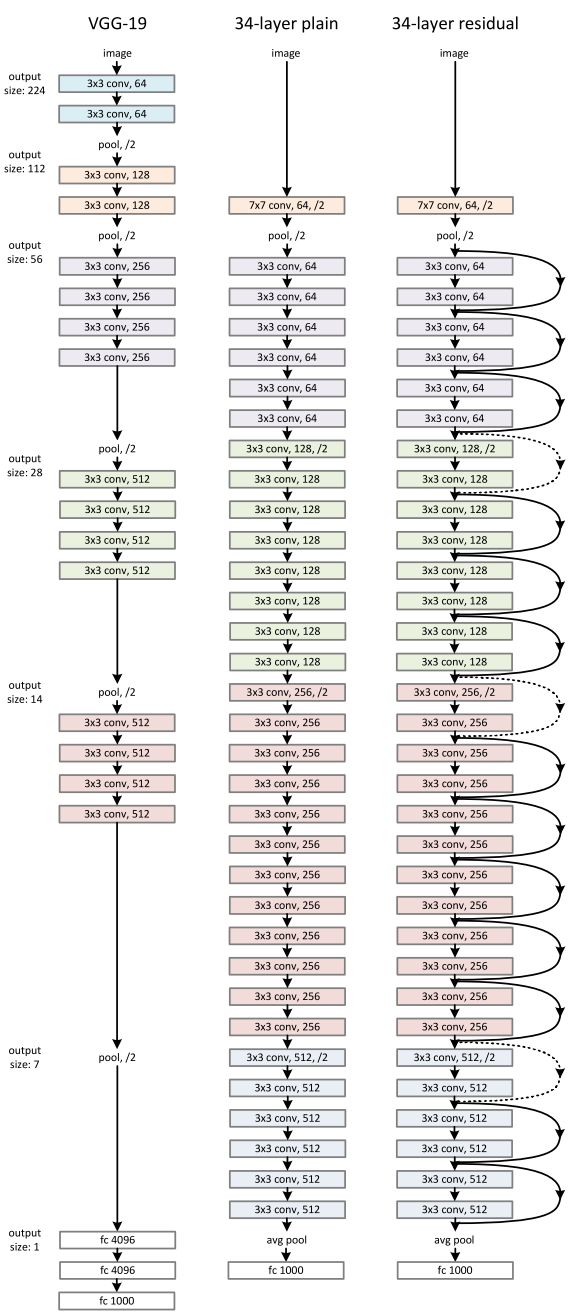

In [ ]:
resnet_model = ResNet50(include_top= True, weights=None, classes=1, classifier_activation='sigmoid',  input_shape=(256, 256, 3))
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# resnet_model.load_weights('/content/gdrive/MyDrive/resnet_model_weights_p2.h5') #loading the weights

In [ ]:
resnet_model.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
history = resnet_model.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=5,verbose=1)

Epoch 1/5
157/157 [==============================] - 278s 2s/step - loss: 0.3008 - accuracy: 0.9063 - val_loss: 1.0559 - val_accuracy: 0.4359
Epoch 2/5
157/157 [==============================] - 264s 2s/step - loss: 0.1363 - accuracy: 0.9513 - val_loss: 1.8570 - val_accuracy: 0.5000
Epoch 3/5
157/157 [==============================] - 264s 2s/step - loss: 0.1240 - accuracy: 0.9542 - val_loss: 0.4013 - val_accuracy: 0.8625
Epoch 4/5
157/157 [==============================] - 264s 2s/step - loss: 0.1100 - accuracy: 0.9587 - val_loss: 0.2195 - val_accuracy: 0.9281
Epoch 5/5
157/157 [==============================] - 264s 2s/step - loss: 0.0820 - accuracy: 0.9704 - val_loss: 0.2780 - val_accuracy: 0.9094


In [ ]:
import json 
with open('/content/gdrive/MyDrive/resnet_orientation.json', 'w') as file:
  json.dump(history.history, file)

In [ ]:
resnet_model.save_weights('/content/gdrive/MyDrive/resnet_model_weights_p2.h5')

#### Evaluating ResNet Model

In [ ]:
with open('/content/gdrive/MyDrive/resnet_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'ResNet50 Model accuracy and loss')

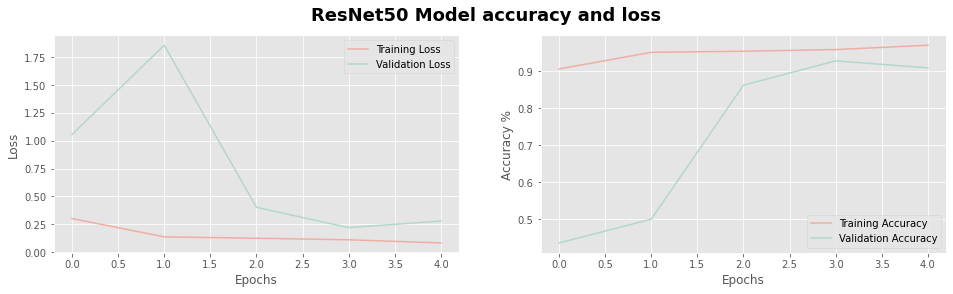

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('ResNet50 Model accuracy and loss', fontsize = 18, fontweight= 'bold')

**Inference**: ResNet also performs really well with an accuracy of over 90% on validation data Let's check it's performance on test datasets 

In [ ]:
resnet_eval_train = resnet_model.evaluate(train_generator)
resnet_eval_train

157/157 [==============================] - 82s 524ms/step - loss: 0.2172 - accuracy: 0.9159


[0.2171805202960968, 0.9158999919891357]

In [ ]:
resnet_eval_val = resnet_model.evaluate(validation_generator)
resnet_eval_val

32/32 [==============================] - 17s 512ms/step - loss: 0.2313 - accuracy: 0.9195


[0.23130695521831512, 0.9194999933242798]

In [ ]:
resnet_eval_test1 = resnet_model.evaluate(test_generator1)
resnet_eval_test1

32/32 [==============================] - 17s 516ms/step - loss: 0.2719 - accuracy: 0.9000


[0.27189841866493225, 0.8999999761581421]

In [ ]:
resnet_eval_test2 = resnet_model.evaluate(test_generator2)
resnet_eval_test2

141/141 [==============================] - 76s 537ms/step - loss: 0.1022 - accuracy: 0.9657


[0.10218924283981323, 0.965666651725769]

**Inference**: The model generalises well on both the test datasets. Test dataset has an accuracy of 0.90 and the test_another dataset has an accuracy of 0.96

#### Saliency Maps for ResNet Model

In [ ]:
#Saliency Map
saliency_resnet = Saliency(resnet_model,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_resnet = Gradcam(resnet_model,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
resnet_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_resnet_test1 = saliency_resnet(loss,
                        np.float32(resnet_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_resnet_test1 = normalize(saliency_resnet_test1)

In [ ]:
#GradCam
gradcam_resnet_test1 = gradcam_resnet(loss, 
              np.float32(resnet_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_resnet_test1 = normalize(gradcam_resnet_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


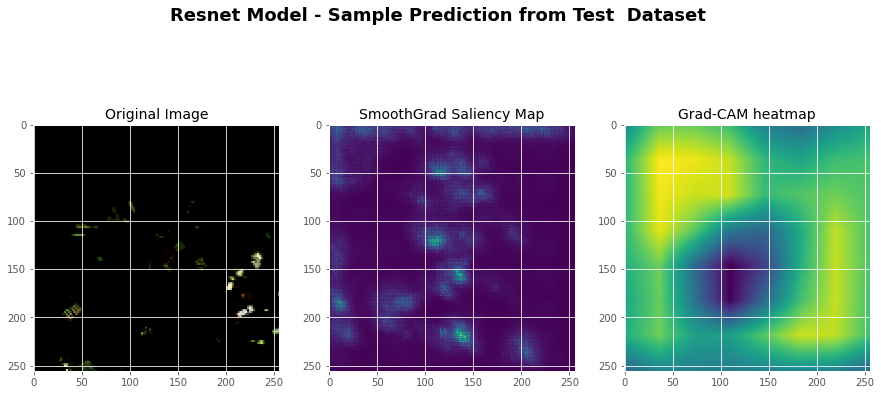

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Resnet Model - Sample Prediction from Test  Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_resnet_test1[0], gradcam_resnet_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
resnet_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_resnet_test2 = saliency_resnet(loss,
                        np.float32(resnet_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_resnet_test2 = normalize(saliency_resnet_test2)

In [ ]:
#GradCam
gradcam_resnet_test2 = gradcam_resnet(loss, 
              np.float32(resnet_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_resnet_test2 = normalize(gradcam_resnet_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


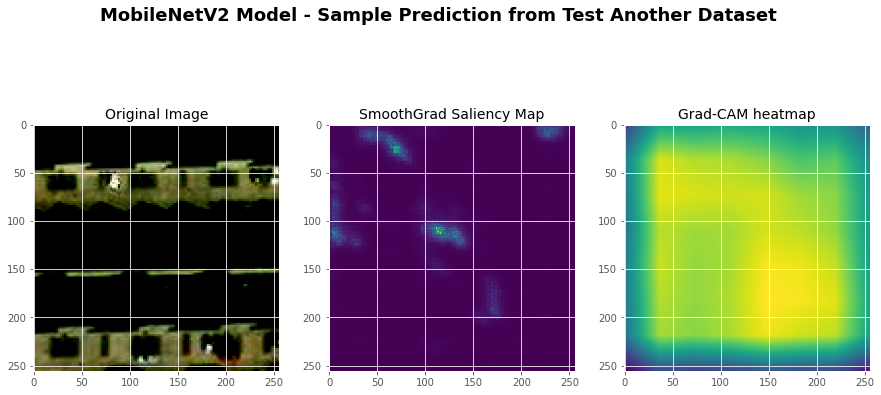

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("MobileNetV2 Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_resnet_test2[0], gradcam_resnet_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

### MobileNetV2 *Model*

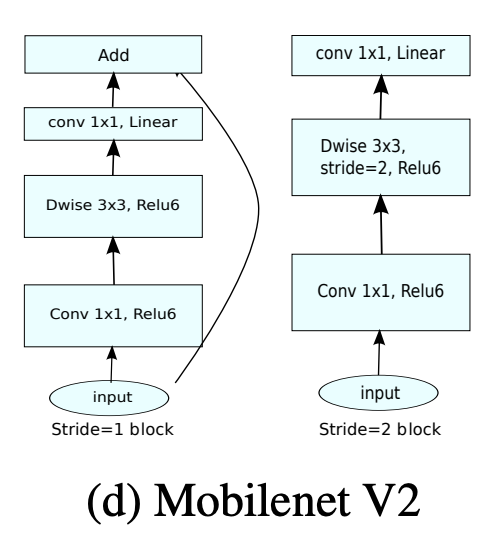

In [ ]:
mobilenetv2_model = MobileNetV2( weights=None, classes=1, classifier_activation='sigmoid', input_shape=(256, 256, 3))
mobilenetv2_model.summary()

Model: "mobilenetv2_1.00_256"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# mobilenetv2_model.load_weights('/content/gdrive/MyDrive/mobilenetv2_weights_p2.h5') #loading the weights

In [ ]:
mobilenetv2_model.compile(optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy',  metrics = 'accuracy')

In [ ]:
history = mobilenetv2_model.fit(train_generator, validation_data = validation_generator, validation_steps=10,epochs=5,verbose=1)

Epoch 1/5
157/157 [==============================] - 146s 927ms/step - loss: 0.2151 - accuracy: 0.9089 - val_loss: 0.7024 - val_accuracy: 0.5094
Epoch 2/5
157/157 [==============================] - 143s 910ms/step - loss: 0.1217 - accuracy: 0.9511 - val_loss: 0.7605 - val_accuracy: 0.4750
Epoch 3/5
157/157 [==============================] - 143s 909ms/step - loss: 0.1011 - accuracy: 0.9605 - val_loss: 0.8298 - val_accuracy: 0.5266
Epoch 4/5
157/157 [==============================] - 143s 908ms/step - loss: 0.0905 - accuracy: 0.9654 - val_loss: 1.0788 - val_accuracy: 0.4766
Epoch 5/5
157/157 [==============================] - 143s 908ms/step - loss: 0.0766 - accuracy: 0.9716 - val_loss: 1.1027 - val_accuracy: 0.5000


In [ ]:
with open('/content/gdrive/MyDrive/mobilenet_orientation.json', 'w') as file:
  json.dump(history.history, file)

In [ ]:
mobilenetv2_model.save_weights('/content/gdrive/MyDrive/mobilenetv2_weights_p2.h5')

#### Evaluating MobileNet Model

In [ ]:
with open('/content/gdrive/MyDrive/mobilenet_orientation.json') as f:
    history = json.load(f)

Text(0.5, 0.98, 'MobileNet Model accuracy and loss')

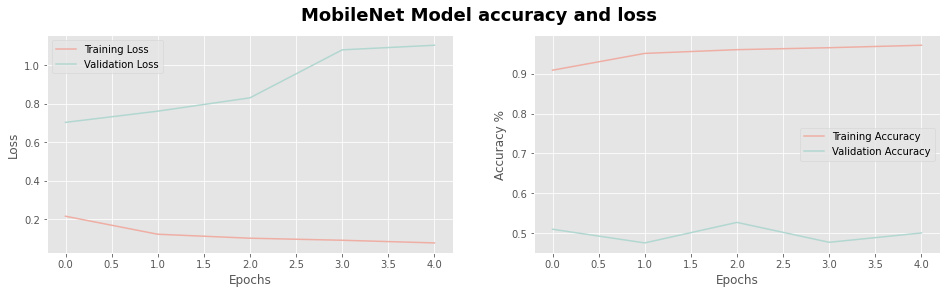

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history['loss'],color='#EFAEA4',label = 'Training Loss')
ax[0].plot(history['val_loss'],color='#B2D7D0',label = 'Validation Loss')
ax[1].plot(history['accuracy'],color='#EFAEA4',label = 'Training Accuracy')
ax[1].plot(history['val_accuracy'],color='#B2D7D0',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('MobileNet Model accuracy and loss', fontsize = 18, fontweight= 'bold')

In [ ]:
mobilenet_eval_train = mobilenetv2_model.evaluate(train_generator)
mobilenet_eval_train

157/157 [==============================] - 32s 200ms/step - loss: 1.1027 - accuracy: 0.5000


[1.1026642322540283, 0.5]

In [ ]:
mobilenet_eval_val = mobilenetv2_model.evaluate(validation_generator)
mobilenet_eval_val

32/32 [==============================] - 6s 196ms/step - loss: 1.1027 - accuracy: 0.5000


[1.1026644706726074, 0.5]

In [ ]:
mobilenet_eval_test1 = mobilenetv2_model.evaluate(test_generator1)
mobilenet_eval_test1

32/32 [==============================] - 6s 196ms/step - loss: 1.1027 - accuracy: 0.5000


[1.1026642322540283, 0.5]

In [ ]:
mobilenet_eval_test2 = mobilenetv2_model.evaluate(test_generator2)
mobilenet_eval_test2

141/141 [==============================] - 29s 205ms/step - loss: 0.3499 - accuracy: 0.8889


[0.34989115595817566, 0.8888888955116272]

**Inference**: Three datasets the model have accuracy at 50%, which is no better than a random gues s. A higher accuracy for the unbalanced dataset (test another) can be explained due to class imbalance 

#### Saliency Maps for MobilNet Model



In [ ]:
#Saliency Map
saliency_mobilenet = Saliency(mobilenetv2_model,
                    model_modifier=model_modifier,
                    clone=False)

In [ ]:
#GradCam map
gradcam_mobilenet = Gradcam(mobilenetv2_model,
                  model_modifier=model_modifier,
                  clone=False)

##### Test Dataset

In [ ]:
mobilenet_testgen1_sample1= test_generator1.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_mobilenet_test1 = saliency_mobilenet(loss,
                        np.float32(mobilenet_testgen1_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_mobilenet_test1 = normalize(saliency_mobilenet_test1)

In [ ]:
#GradCam
gradcam_mobilenet_test1 = gradcam_mobilenet(loss, 
              np.float32(mobilenet_testgen1_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_mobilenet_test1 = normalize(gradcam_mobilenet_test1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


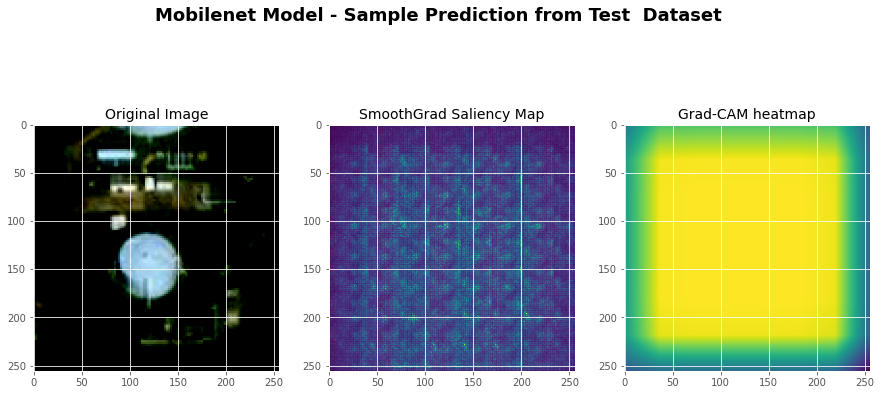

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Mobilenet Model - Sample Prediction from Test  Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator1.next()[0][6], saliency_mobilenet_test1[0], gradcam_mobilenet_test1[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()

##### Test Another Dataset

In [ ]:
mobilenet_testgen2_sample1= test_generator2.next()[0][6].reshape(1, 256, 256, 3)

In [ ]:
saliency_mobilenet_test2 = saliency_mobilenet(loss,
                        np.float32(mobilenet_testgen2_sample1),
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.20)
saliency_mobilenet_test2 = normalize(saliency_mobilenet_test2)

In [ ]:
#GradCam
gradcam_mobilenet_test2 = gradcam_mobilenet(loss, 
              np.float32(mobilenet_testgen2_sample1),
              penultimate_layer=-1, # model.layers number
             )
gradcam_mobilenet_test2 = normalize(gradcam_mobilenet_test2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


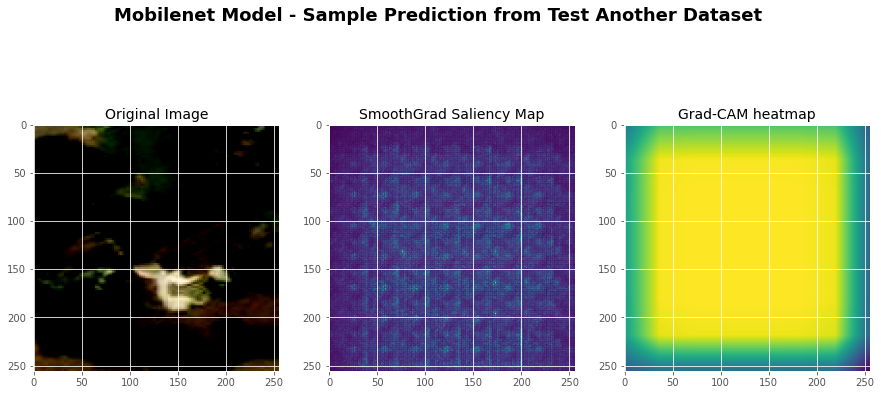

In [ ]:
plt.style.use('seaborn-pastel')
fig, ax = plt.subplots(1,3, figsize = (15, 7))
fig.suptitle("Mobilenet Model - Sample Prediction from Test Another Dataset", fontweight="bold", fontsize=18)

imgs = [test_generator2.next()[0][6], saliency_mobilenet_test2[0], gradcam_mobilenet_test2[0]]

for i in range(1):      #Loop to iteratively define each plot
    for j in range(3):
        ax[j].imshow(imgs[j])
ax[0].set_title("Original Image", fontsize = 14)   
ax[1].set_title("SmoothGrad Saliency Map", fontsize = 14)  
ax[2].set_title("Grad-CAM heatmap", fontsize = 14)     
        
plt.show()